In [35]:
import numpy as np
import tensorflow as tf
import logging
import sys
import logging
from contextlib import redirect_stdout
from Environment import *
from collections import deque
import gym
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
import keras.backend as k
# Import everything neede for the DQN - keras implementation
from rl.agents import DQNAgent
from rl.policy import EpsGreedyQPolicy
from rl.policy import LinearAnnealedPolicy
from rl.memory import SequentialMemory
from proc import OneHotNNInputProcessor
from Custom_Callbacks import TrainingMetricsCallback, plot_training_metrics

In [36]:
WINDOW_LENGTH = 1
NUM_ACTIONS_NN = 4
INPUT_SHAPE = (4, 4)

NUM_ONE_HOT_MATRICES = 16

# training hyperparameters
NB_STEPS_TRAINING = 10000
NB_STEPS_ANNEALED = 3000
NB_STEPS_WARMUP = 2000
MEMORY_SIZE = 6000
TARGET_MODEL_UPDATE = 1000

weights_filepath = "DQN_2048_model_0.h5"

In [37]:
# Initialize environment
env = Game2048Env()

# Set specific seed for random number generator
random_seed = 123
random.seed(random_seed)
np.random.seed(random_seed)
env.seed(random_seed)

[123]

In [38]:
# To accomodate for the one hot encoding
INPUT_SHAPE_DNN = (WINDOW_LENGTH, 4 + 4 * 4, NUM_ONE_HOT_MATRICES,) + INPUT_SHAPE
processor = OneHotNNInputProcessor(num_one_hot_matrices=NUM_ONE_HOT_MATRICES)

# Dnn model definition
model = Sequential()
model.add(Flatten(input_shape=INPUT_SHAPE_DNN))
model.add(Dense(units=1024, activation='relu'))
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=4, activation='linear'))
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 5120)              0         
                                                                 
 dense_12 (Dense)            (None, 1024)              5243904   
                                                                 
 dense_13 (Dense)            (None, 512)               524800    
                                                                 
 dense_14 (Dense)            (None, 256)               131328    
                                                                 
 dense_15 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 5,901,060
Trainable params: 5,901,060
Non-trainable params: 0
_________________________________________________________________
None


In [39]:
# Defining memory for the model
memory = SequentialMemory(limit=MEMORY_SIZE, window_length=WINDOW_LENGTH)

# Training policy
TRAIN_POLICY = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=0.05, value_min=0.05, value_test=0.01, nb_steps=NB_STEPS_ANNEALED)
# Test policy
TEST_POLICY = EpsGreedyQPolicy(eps=0.1)

In [40]:
# Defining the dqn agent
dqn = DQNAgent(
    model=model,
    nb_actions=4,
    test_policy=TEST_POLICY,
    policy=TRAIN_POLICY,
    memory=memory,
    processor=processor,
    nb_steps_warmup=NB_STEPS_WARMUP,
    gamma=0.99,
    target_model_update=TARGET_MODEL_UPDATE,
    train_interval=4,
    delta_clip=1.
)

dqn.compile(Adam(learning_rate=0.00025), metrics=['mse'])

In [41]:
# Callbacks for plotting
training_callback = TrainingMetricsCallback()

# Actually training the agent
dqn.fit(env, nb_steps=NB_STEPS_TRAINING, visualize=True, verbose=1, callbacks=[training_callback])

# Save the final weights one more time after training completed
dqn.save_weights(weights_filepath, overwrite=True)

Training for 10000 steps ...
Interval 1 (0 steps performed)
Action received by environment: 0
Score: 0.0
Highest: 2
[[2 0 2 0]
 [0 2 0 0]
 [0 0 0 0]
 [0 0 0 0]]
    1/10000 [..............................] - ETA: 19:52 - reward: 8.5000Action received by environment: 2
Score: 0.0
Highest: 4
[[0 0 0 0]
 [0 0 0 0]
 [4 0 0 0]
 [2 2 2 0]]
Action received by environment: 3
Score: 4.0
Highest: 4
[[0 0 4 0]
 [0 0 0 0]
 [4 0 0 0]
 [4 2 0 0]]
Action received by environment: 3
Score: 4.0
Highest: 4
[[4 0 0 0]
 [0 0 0 0]
 [4 4 0 0]
 [4 2 0 0]]
Action received by environment: 3
Score: 12.0
Highest: 8
[[4 0 0 0]
 [4 0 0 0]
 [8 0 0 0]
 [4 2 0 0]]
Action received by environment: 3
Score: 12.0
Highest: 8
[[4 0 0 0]
 [4 0 0 0]
 [8 0 0 0]
 [4 2 0 0]]
Action received by environment: 3
Score: 12.0
Highest: 8
[[4 0 0 0]
 [4 0 0 0]
 [8 0 0 0]
 [4 2 0 0]]
Action received by environment: 3
Score: 12.0
Highest: 8
[[4 0 0 0]
 [4 0 0 0]
 [8 0 0 0]
 [4 2 0 0]]
Action received by environment: 3
Score: 12.0
Highest:

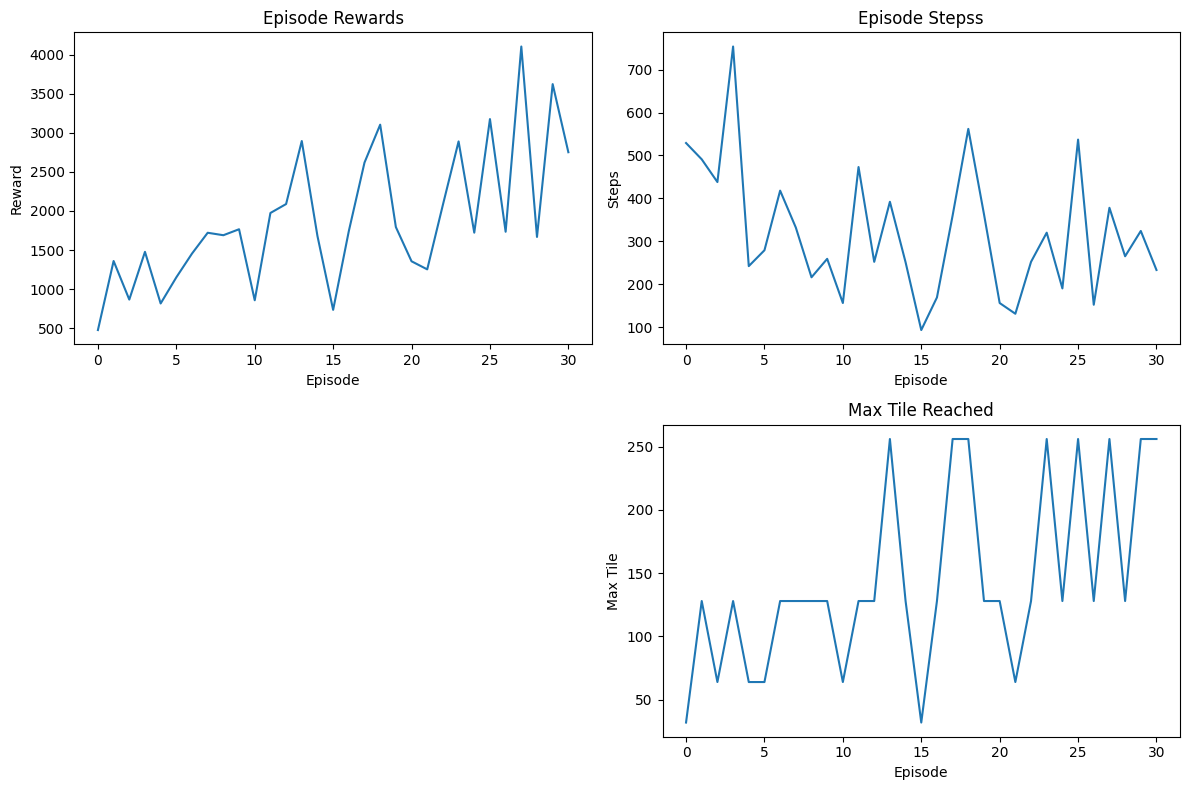

In [42]:
# Plot the training metrics
plot_training_metrics(training_callback)

In [13]:
# Test the environment
env.reset()

dqn.test(env, nb_episodes=5, visualize=True, verbose=0)

Action received by environment: 3
Score: 0.0
Highest: 2
[[0 0 0 0]
 [2 0 0 0]
 [0 0 0 2]
 [2 0 0 0]]
Action received by environment: 0
Score: 4.0
Highest: 4
[[4 0 0 2]
 [0 0 2 0]
 [0 0 0 0]
 [0 0 0 0]]
Action received by environment: 3
Score: 4.0
Highest: 4
[[4 2 0 0]
 [2 0 0 0]
 [0 0 0 0]
 [0 2 0 0]]
Action received by environment: 1
Score: 4.0
Highest: 4
[[0 0 4 2]
 [0 0 0 2]
 [0 0 0 0]
 [2 0 0 2]]
Action received by environment: 3
Score: 8.0
Highest: 4
[[4 2 0 0]
 [2 0 0 0]
 [0 0 0 0]
 [4 4 0 0]]
Action received by environment: 1
Score: 16.0
Highest: 8
[[0 0 4 2]
 [0 0 0 2]
 [0 0 0 0]
 [2 0 0 8]]
Action received by environment: 3
Score: 16.0
Highest: 8
[[4 2 0 0]
 [2 0 0 2]
 [0 0 0 0]
 [2 8 0 0]]
Action received by environment: 1
Score: 20.0
Highest: 8
[[0 0 4 2]
 [0 0 0 4]
 [0 0 0 0]
 [0 2 2 8]]
Action received by environment: 3
Score: 24.0
Highest: 8
[[4 2 0 0]
 [4 0 0 0]
 [0 0 2 0]
 [4 8 0 0]]
Action received by environment: 0
Score: 32.0
Highest: 8
[[8 2 2 0]
 [4 8 0 0]
 [0 0 0 